In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from typing import TypedDict, List, Annotated
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver

import os
from dotenv import load_dotenv
load_dotenv()


# v1 - Simple Chatbot

True

In [2]:
# Model 

repo_id = "meta-llama/Llama-3.1-8B-Instruct"
# repo_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
endpoint = HuggingFaceEndpoint(
            repo_id= repo_id,
            max_new_tokens= 128,
            temperature= 0.2,
            huggingfacehub_api_token= os.getenv('HUGGINGFACEHUB_API_TOKEN'))
llm = ChatHuggingFace(llm= endpoint)

e:\AI-LLMs\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# State

class JokeState(TypedDict):
    topic: str
    joke: str
    explaination: str

In [4]:
# Nodes/functions

def generate_joke(state : JokeState)-> JokeState:
    topic = state["topic"]
    prompt = f" Generate a funny and witty joke based on : {topic}"
    
    response = llm.invoke(prompt)
    partial_state = { "joke": response.content}
    return partial_state

def generate_explaination(state : JokeState)-> JokeState:
    topic = state["topic"]
    joke = state["joke"]
    prompt = f" Explain this joke : {joke}  based on the topic of {topic}"
    
    response = llm.invoke(prompt)
    return {"explaination":response.content}


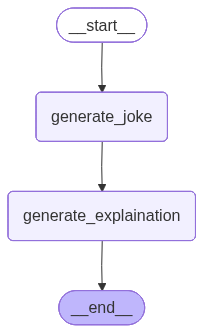

In [5]:
# Graph 

graph = StateGraph(state_schema= JokeState)

graph.add_node("generate_joke", generate_joke)
graph.add_node("generate_explaination", generate_explaination)

# Adding Edges
    # Start
graph.add_edge(START, "generate_joke")
graph.add_edge("generate_joke", "generate_explaination")
graph.add_edge("generate_explaination", END)

checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer= checkpointer)

workflow

In [6]:
topic= """ Donald the duck"""

init_state = {
  "topic": topic
}

# We must provide config with thread_id to run with checkpointer

config1 = {"configurable":{"thread_id":1}}
final_state = workflow.invoke(init_state, config=config1)

final_state

{'topic': ' Donald the duck',
 'joke': "Why did Donald the duck go to therapy? \n\nBecause he had fowl temper and couldn't quack out his problems!",
 'explaination': 'The joke relies on a play on words and puns related to Donald the duck\'s characteristics.\n\n"Have a fowl temper" is a double meaning phrase here. "Fowl" is a pun on "foul" (meaning having a bad temper), but since Donald is a duck (a type of bird, often referred to as "fowl" in a colloquial sense), it makes the phrase funnier. So, the joke is using Donald\'s species ("fowl") to create a wordplay on the common phrase "bad temper."\n\nThe second part, "couldn\'t quack out his problems," is another play on words referencing Donald the duck\'s distinctive call, which is a quack. So, the joke is making a clever connection between Donald\'s speech (quacking) and the common phrase "speak out" or "vent" one\'s problems.\n\nOverall, the joke is lighthearted and silly, using Donald the duck\'s character to create a pun-filled punc

In [7]:
# Get all the snapshot of the final state at this point stored 
# in the graph
workflow.get_state(config=config1)

StateSnapshot(values={'topic': ' Donald the duck', 'joke': "Why did Donald the duck go to therapy? \n\nBecause he had fowl temper and couldn't quack out his problems!", 'explaination': 'The joke relies on a play on words and puns related to Donald the duck\'s characteristics.\n\n"Have a fowl temper" is a double meaning phrase here. "Fowl" is a pun on "foul" (meaning having a bad temper), but since Donald is a duck (a type of bird, often referred to as "fowl" in a colloquial sense), it makes the phrase funnier. So, the joke is using Donald\'s species ("fowl") to create a wordplay on the common phrase "bad temper."\n\nThe second part, "couldn\'t quack out his problems," is another play on words referencing Donald the duck\'s distinctive call, which is a quack. So, the joke is making a clever connection between Donald\'s speech (quacking) and the common phrase "speak out" or "vent" one\'s problems.\n\nOverall, the joke is lighthearted and silly, using Donald the duck\'s character to creat

In [8]:
# Get the states at all checkpoints
list(workflow.get_state_history(config= config1))

[StateSnapshot(values={'topic': ' Donald the duck', 'joke': "Why did Donald the duck go to therapy? \n\nBecause he had fowl temper and couldn't quack out his problems!", 'explaination': 'The joke relies on a play on words and puns related to Donald the duck\'s characteristics.\n\n"Have a fowl temper" is a double meaning phrase here. "Fowl" is a pun on "foul" (meaning having a bad temper), but since Donald is a duck (a type of bird, often referred to as "fowl" in a colloquial sense), it makes the phrase funnier. So, the joke is using Donald\'s species ("fowl") to create a wordplay on the common phrase "bad temper."\n\nThe second part, "couldn\'t quack out his problems," is another play on words referencing Donald the duck\'s distinctive call, which is a quack. So, the joke is making a clever connection between Donald\'s speech (quacking) and the common phrase "speak out" or "vent" one\'s problems.\n\nOverall, the joke is lighthearted and silly, using Donald the duck\'s character to crea

In [12]:
checkpoint_id1 = "1f091983-c990-666b-8001-a209ac310c3b"

workflow.get_state({"configurable":{"thread_id":1,"checkpoint_id":checkpoint_id1}})

StateSnapshot(values={'topic': ' Donald the duck', 'joke': "Why did Donald the duck go to therapy? \n\nBecause he had fowl temper and couldn't quack out his problems!"}, next=('generate_explaination',), config={'configurable': {'thread_id': '1', 'checkpoint_id': '1f091983-c990-666b-8001-a209ac310c3b'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-09-14T18:25:48.620349+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f091983-aec6-6009-8000-941b362eb9b9'}}, tasks=(PregelTask(id='ac87ae79-4415-a4c7-02df-6e29d6c69f2e', name='generate_explaination', path=('__pregel_pull', 'generate_explaination'), error=None, interrupts=(), state=None, result={'explaination': 'The joke relies on a play on words and puns related to Donald the duck\'s characteristics.\n\n"Have a fowl temper" is a double meaning phrase here. "Fowl" is a pun on "foul" (meaning having a bad temper), but since Donald is a duck (a type of bird, often refe

In [10]:
config2 = {"configurable":{"thread_id":2}}
final_state = workflow.invoke({"topic":"pizza"}, config= config2)
final_state

{'topic': 'pizza',
 'joke': 'Why did the pizza go to therapy?\n\nBecause it was feeling crusty under pressure.',
 'explaination': 'This joke plays on a double meaning of the word "crusty". In one sense, a crust is the outer layer of a pizza. However, "crusty" can also describe someone who appears or feels aloof, grumpy, or irritable. \n\nIn the joke, the punchline "because it was feeling crusty under pressure" implies that the pizza is experiencing anxiety (under pressure) and as a result, it\'s becoming grumpy or difficult to handle (feeling crusty). The use of the wordplay between the literal pizza crust and the emotional state of being "crusty" creates a humorous effect, highlighting the pizza\'s emotional struggles.'}

In [11]:
workflow.get_state(config= config2)

StateSnapshot(values={'topic': 'pizza', 'joke': 'Why did the pizza go to therapy?\n\nBecause it was feeling crusty under pressure.', 'explaination': 'This joke plays on a double meaning of the word "crusty". In one sense, a crust is the outer layer of a pizza. However, "crusty" can also describe someone who appears or feels aloof, grumpy, or irritable. \n\nIn the joke, the punchline "because it was feeling crusty under pressure" implies that the pizza is experiencing anxiety (under pressure) and as a result, it\'s becoming grumpy or difficult to handle (feeling crusty). The use of the wordplay between the literal pizza crust and the emotional state of being "crusty" creates a humorous effect, highlighting the pizza\'s emotional struggles.'}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f091983-e1f9-6fc1-8002-e5b323a4f4f5'}}, metadata={'source': 'loop', 'step': 2, 'parents': {}}, created_at='2025-09-14T18:25:51.180179+00:00', parent_config=